# Aumentemos la capa de la estructura de la RNN_01

In [103]:
from RNNs_sentimiento01 import RNNode
from RNNs_sentimiento01 import Preprocessor

In [104]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class RNN_ANN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(RNN_ANN2, self).__init__()

        # Atributos (tipo RNNode)
        self.cell = RNNode(input_size=input_size, hidden_size=hidden_size)

        # Añadiendo más capas ANN para el procesamiento posterior
        self.fc1 = nn.Linear(hidden_size, hidden_size)  # Nueva capa lineal
        self.relu1 = nn.ReLU()  # Función de activación ReLU
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  # Otra capa lineal, reduce dimensiones
        self.relu2 = nn.ReLU()  # Otra ReLU
        self.f_sent = nn.Linear(hidden_size // 2, output_size)  # Capa final ajustada después de nuevas capas

    def forward(self, secuencia, h=None):
        for x_input in secuencia:
            h = self.cell(x_input, h)

        # Pasando el estado oculto final a través de las capas adicionales
        x = self.fc1(h)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        output = self.f_sent(x)
        output = torch.tanh(output)  # Manteniendo la función de activación tanh para la salida
        output = output.squeeze()  # Eliminando dimensiones extra

        return output


In [105]:
class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, Preprocessor, dropout=0.5, lr=0.001):
        super(SentimentRNN, self).__init__()
        self.Preprocessor = Preprocessor
        self.model = RNN_ANN2(input_size, hidden_size, output_size)
        self.loss = nn.MSELoss()
        self.dropout = nn.Dropout(dropout)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, X_train, y_train, epoch=10, batch_size=32):
        loss_list = []
        for e in range(epoch):
            total_loss = 0
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                self.optimizer.zero_grad()
                outputs = []
                for secuencia in X_batch:
                    output = self.model(secuencia)
                    outputs.append(output)

                outputs = torch.stack(outputs).squeeze()
                loss = self.loss(outputs, torch.tensor(y_batch))
                
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                #
            loss_list.append(total_loss)
            print(f'Epoch {e+1} - Loss: {total_loss}')
        self.loss_list = loss_list

    def plot_loss(self):
        plt.plot(self.loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def evaluate(self, X_test, y_test):
        with torch.no_grad():
            total_loss = 0
            outputs = []
            for secuencia in X_test:
                output = self.model(secuencia)
                outputs.append(output)
            outputs = torch.stack(outputs).squeeze()
            total_loss = self.loss(outputs, torch.tensor(y_test)).item()
            mse = total_loss / len(y_test)
            print(f'MSE: {mse}')
        return mse

    def predict(self, texto):
        secuencia = self.Preprocessor.get_embedding_texto(texto)
        output = self.model(secuencia)
        return output.item()


In [106]:
# Crear el preprocesador
preprocessor_train = Preprocessor('./train_data.txt', embedding_type='glove')


# Crear el modelo
model = SentimentRNN(input_size=100, hidden_size=300, output_size=1, Preprocessor=preprocessor_train, dropout=0.5, lr=0.001)

Cargando GloVe...


In [107]:
model.train(preprocessor_train.X, preprocessor_train.y, epoch=100)

Epoch 1 - Loss: 4.49678543349728
Epoch 2 - Loss: 4.032744410447776
Epoch 3 - Loss: 3.658465313492343
Epoch 4 - Loss: 3.1708917059004307
Epoch 5 - Loss: 2.5008729491382837
Epoch 6 - Loss: 1.8038499131798744
Epoch 7 - Loss: 1.6426320374011993
Epoch 8 - Loss: 1.758798535913229
Epoch 9 - Loss: 1.3311868319287896
Epoch 10 - Loss: 1.2614108640700579
Epoch 11 - Loss: 1.1776444409042597
Epoch 12 - Loss: 0.9422411751002073
Epoch 13 - Loss: 0.6262879632413387
Epoch 14 - Loss: 0.4967250544577837
Epoch 15 - Loss: 0.41904175747185946
Epoch 16 - Loss: 0.3483002698048949
Epoch 17 - Loss: 0.23924302868545055
Epoch 18 - Loss: 0.21055614668875933
Epoch 19 - Loss: 0.16718642273917794
Epoch 20 - Loss: 0.14626609510742128
Epoch 21 - Loss: 0.1619141495320946
Epoch 22 - Loss: 0.10166451963596046
Epoch 23 - Loss: 0.09316096443217248
Epoch 24 - Loss: 0.07859945384552702
Epoch 25 - Loss: 0.05698992818361148
Epoch 26 - Loss: 0.051324103376828134
Epoch 27 - Loss: 0.04509482445428148
Epoch 28 - Loss: 0.02162417574

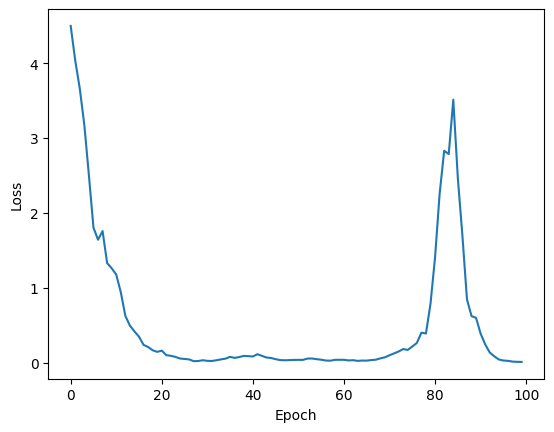

In [108]:
# Ploteamos la pérdida
model.plot_loss()

In [112]:
# Evaluar el modelo
preprocessor_test = Preprocessor('./test_data.txt', embedding_type='glove')

Cargando GloVe...


In [113]:
# Evaluar el modelo
model.evaluate(preprocessor_test.X, preprocessor_test.y)

MSE: 0.01984870433807373


0.01984870433807373

In [114]:
# Predecimos el sentimiento de un texto
texto = 'Creo la vida es divertida pero a veces es difícil'
sentimiento = model.predict(texto)
print(f'Sentimiento: {sentimiento}')

Sentimiento: 0.07966874539852142


In [115]:
# Oraciones a probar
sentences = [
    'La vida es hermosa',
    'La vida es triste',
    'La vida es un juego',
    'La vida es un sueño',
    'Tengo mucho trabajo',
    'No tengo trabajo',
    'Quiero jugar en la noche',
    'A veces creo que el simple hecho de vivir es un milagro',
    'A veces creo que cuando todo sale mal, es porque algo mejor está por venir',
    'Uno nunca sabe lo que tiene hasta que lo pierde',
    'La vida es un regalo',
    'La felicidad es parte de vivir? o la vida siempre va ser una desgracia?',
    'Opino que el hecho de vivir en este mundo es una desgracia, fuimos condenados a tener que trabajar y vivir malas experiencias',
    'Opino que el hecho de vivir en este mundo es una bendición, fuimos premiados con la oportunidad de vivir y disfrutar de la vida',
]

In [116]:
# Probamos el modelo con las oraciones
for sentence in sentences:
    sentiment = model.predict(sentence)
    print(f'Sentimiento de "{sentence}": {sentiment}')

Sentimiento de "La vida es hermosa": 0.826107919216156
Sentimiento de "La vida es triste": -0.6909604072570801
Sentimiento de "La vida es un juego": 0.3330773413181305
Sentimiento de "La vida es un sueño": 0.4011445939540863
Sentimiento de "Tengo mucho trabajo": -0.0029476729687303305
Sentimiento de "No tengo trabajo": -0.5103658437728882
Sentimiento de "Quiero jugar en la noche": 0.22261609137058258
Sentimiento de "A veces creo que el simple hecho de vivir es un milagro": 0.7077626585960388
Sentimiento de "A veces creo que cuando todo sale mal, es porque algo mejor está por venir": 0.5068033337593079
Sentimiento de "Uno nunca sabe lo que tiene hasta que lo pierde": -0.4012337028980255
Sentimiento de "La vida es un regalo": 0.7233216166496277
Sentimiento de "La felicidad es parte de vivir? o la vida siempre va ser una desgracia?": -0.6212287545204163
Sentimiento de "Opino que el hecho de vivir en este mundo es una desgracia, fuimos condenados a tener que trabajar y vivir malas experien

In [117]:
sentences = [
    "A veces siento que el esfuerzo vale la pena, aunque el camino sea difícil",
    "La vida nos sorprende con momentos inesperados que nos enseñan grandes lecciones",
    "Hoy me siento en paz, sin preocupaciones que alteren mi tranquilidad",
    "Los desafíos son oportunidades para crecer y fortalecer nuestro carácter",
    "Quisiera entender por qué algunas cosas suceden sin razón aparente",
    "Cada sonrisa es un pequeño recordatorio de las cosas buenas de la vida",
    "La paciencia me ayuda a enfrentar las situaciones difíciles con calma",
    "Es reconfortante pensar que siempre hay algo nuevo por aprender",
    "La vida no siempre es justa, pero trato de aceptar las cosas como son",
    "Aprecio los momentos de silencio, son espacios para reflexionar y crecer"
]


In [118]:
# Probamos el modelo con las oraciones
# Almacenamos en una lista los sentimientos de cada oración
sentiments = []
for sentence in sentences:
    sentiment = model.predict(sentence)
    sentiments.append(sentiment)
    print(f'Sentimiento de "{sentence}": {sentiment}')

Sentimiento de "A veces siento que el esfuerzo vale la pena, aunque el camino sea difícil": -0.002677856246009469
Sentimiento de "La vida nos sorprende con momentos inesperados que nos enseñan grandes lecciones": 0.13729697465896606
Sentimiento de "Hoy me siento en paz, sin preocupaciones que alteren mi tranquilidad": -0.015160203911364079
Sentimiento de "Los desafíos son oportunidades para crecer y fortalecer nuestro carácter": 0.5388038158416748
Sentimiento de "Quisiera entender por qué algunas cosas suceden sin razón aparente": -0.11640710383653641
Sentimiento de "Cada sonrisa es un pequeño recordatorio de las cosas buenas de la vida": 0.17104217410087585
Sentimiento de "La paciencia me ayuda a enfrentar las situaciones difíciles con calma": 0.0651886984705925
Sentimiento de "Es reconfortante pensar que siempre hay algo nuevo por aprender": 0.3773796558380127
Sentimiento de "La vida no siempre es justa, pero trato de aceptar las cosas como son": 0.15624549984931946
Sentimiento de "A

# Usamos el embedding de Word2vec

In [119]:
# definimos el preprocesador
preprocessor_train_word2vec = Preprocessor('./train_data.txt', embedding_type='word2vec')

Cargando Word2Vec...


In [120]:
# Crear el modelo
model_word2vec = SentimentRNN(input_size=300, hidden_size=300, output_size=1, Preprocessor=preprocessor_train_word2vec, dropout=0.5, lr=0.001)

In [121]:
# Entrenamos el modelo
model_word2vec.train(preprocessor_train_word2vec.X, preprocessor_train_word2vec.y, epoch=100, batch_size=32)

Epoch 1 - Loss: 4.281173239927739
Epoch 2 - Loss: 4.130338530289009
Epoch 3 - Loss: 4.105589230544865
Epoch 4 - Loss: 3.815966507419944
Epoch 5 - Loss: 3.47546892426908
Epoch 6 - Loss: 3.0070141330361366
Epoch 7 - Loss: 2.8903326895087957
Epoch 8 - Loss: 2.7272773683071136
Epoch 9 - Loss: 2.5710011050105095
Epoch 10 - Loss: 2.4334477074444294
Epoch 11 - Loss: 2.0301875956356525
Epoch 12 - Loss: 1.9898205026984215
Epoch 13 - Loss: 1.7275177696719766
Epoch 14 - Loss: 1.6871683076024055
Epoch 15 - Loss: 1.3241529501974583
Epoch 16 - Loss: 1.1106266733258963
Epoch 17 - Loss: 1.023875292390585
Epoch 18 - Loss: 0.886476518586278
Epoch 19 - Loss: 0.58161192946136
Epoch 20 - Loss: 0.526205831207335
Epoch 21 - Loss: 0.5326532712206244
Epoch 22 - Loss: 0.5460632583126426
Epoch 23 - Loss: 0.5725648617371917
Epoch 24 - Loss: 0.3768420806154609
Epoch 25 - Loss: 0.34871378680691123
Epoch 26 - Loss: 0.34218817623332143
Epoch 27 - Loss: 0.2871631891466677
Epoch 28 - Loss: 0.3377394871786237
Epoch 29 -

In [122]:
sentences = [
    "A veces siento que el esfuerzo vale la pena, aunque el camino sea difícil",
    "La vida nos sorprende con momentos inesperados que nos enseñan grandes lecciones",
    "Hoy me siento en paz, sin preocupaciones que alteren mi tranquilidad",
    "Los desafíos son oportunidades para crecer y fortalecer nuestro carácter",
    "Quisiera entender por qué algunas cosas suceden sin razón aparente",
    "Cada sonrisa es un pequeño recordatorio de las cosas buenas de la vida",
    "La paciencia me ayuda a enfrentar las situaciones difíciles con calma",
    "Es reconfortante pensar que siempre hay algo nuevo por aprender",
    "La vida no siempre es justa, pero trato de aceptar las cosas como son",
    "Aprecio los momentos de silencio, son espacios para reflexionar y crecer"
]

# Probamos el modelo con las oraciones
# Almacenamos en una lista los sentimientos de cada oración
sentiments_word2vec = []
for sentence in sentences:
    sentiment_word2vec = model_word2vec.predict(sentence)
    sentiments_word2vec.append(sentiment_word2vec)
    print(f'Sentimiento de "{sentence}": {sentiment_word2vec}')

Sentimiento de "A veces siento que el esfuerzo vale la pena, aunque el camino sea difícil": 0.48890334367752075
Sentimiento de "La vida nos sorprende con momentos inesperados que nos enseñan grandes lecciones": 0.46778637170791626
Sentimiento de "Hoy me siento en paz, sin preocupaciones que alteren mi tranquilidad": 0.29573363065719604
Sentimiento de "Los desafíos son oportunidades para crecer y fortalecer nuestro carácter": 0.31268104910850525
Sentimiento de "Quisiera entender por qué algunas cosas suceden sin razón aparente": -0.018703212961554527
Sentimiento de "Cada sonrisa es un pequeño recordatorio de las cosas buenas de la vida": 0.6952030062675476
Sentimiento de "La paciencia me ayuda a enfrentar las situaciones difíciles con calma": 0.49930548667907715
Sentimiento de "Es reconfortante pensar que siempre hay algo nuevo por aprender": 0.3066975474357605
Sentimiento de "La vida no siempre es justa, pero trato de aceptar las cosas como son": -0.02927745319902897
Sentimiento de "Ap

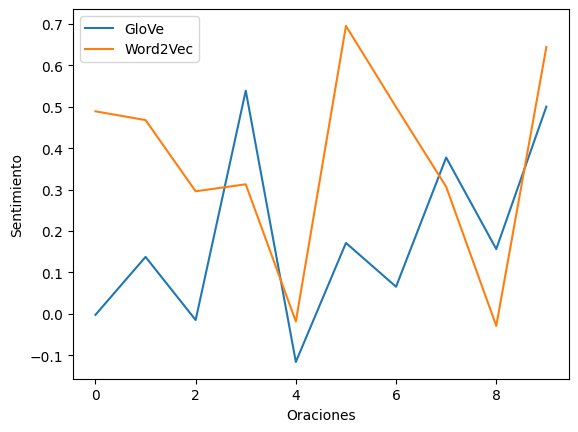

In [123]:
# Comparamos en un gráfico los sentimientos de las oraciones con los dos modelos
plt.plot(sentiments, label='GloVe')
plt.plot(sentiments_word2vec, label='Word2Vec')
plt.xlabel('Oraciones')
plt.ylabel('Sentimiento')
plt.legend()
plt.show()

In [124]:
import plotly.graph_objects as go

# Función para evaluar modelos y graficar resultados
def evaluate_models_sentences(sentences, model1, model2, target_sentence):
    sentiments_model1 = []
    sentiments_model2 = []
    
    for sentence in sentences:
        sentiment_model1 = model1.predict(sentence)
        sentiment_model2 = model2.predict(sentence)
        sentiments_model1.append(sentiment_model1)
        sentiments_model2.append(sentiment_model2)
        print(f'Sentimiento de "{sentence}": {sentiment_model1} - {sentiment_model2}')
    
    # Crear gráfico de barras interactivo con Plotly
    index = list(range(len(sentences)))
    
    fig = go.Figure()
    
    # Agregar barras para cada modelo y los targets
    fig.add_trace(go.Bar(
        x=index,
        y=sentiments_model1,
        name='GloVe',
        text=sentences,  # etiquetas de las oraciones
        hoverinfo="text+y"
    ))

    fig.add_trace(go.Bar(
        x=[i + 0.2 for i in index],  # desplazamiento
        y=sentiments_model2,
        name='Word2Vec',
        text=sentences,
        hoverinfo="text+y"
    ))

    fig.add_trace(go.Bar(
        x=[i + 0.4 for i in index],  # desplazamiento
        y=target_sentence,
        name='Target',
        text=sentences,
        hoverinfo="text+y"
    ))

    # Actualizar diseño del gráfico
    fig.update_layout(
        title="Comparación de Sentimientos entre Modelos",
        xaxis=dict(
            title="Oraciones",
            tickvals=index,
            ticktext=[f'Oración {i+1}' for i in index],  # etiquetas en el eje x
        ),
        yaxis=dict(title="Sentimiento"),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1,
        legend=dict(title="Modelo")
    )
    
    # Mostrar gráfico interactivo
    fig.show()

    # Calculo de los errores cuadráticos medios
    mse1 = 0
    mse2 = 0
    for sent_pred1, sent_pred2, sent_target in zip(sentiments_model1, sentiments_model2, target_sentence):
        mse1 += (sent_pred1 - sent_target) ** 2
        mse2 += (sent_pred2 - sent_target) ** 2
    
    mse1 /= len(sentiments_model1)
    mse2 /= len(sentiments_model2)

    # Imprimimos los errores cuadráticos medios
    print(f'MSE GloVe: {mse1}')
    print(f'MSE Word2Vec: {mse2}')

    return  mse1, mse2



In [125]:
# Definimos las oraciones a evaluar
sentences = [
    'Hoy siento que tengo mucha energía y entusiasmo',
    'La vida no siempre es fácil, pero hay que seguir adelante',
    'Estoy cansado de todo, nada parece tener sentido',
    'Hoy fue un día normal, sin muchas novedades',
    'Me encanta pasar tiempo con mis amigos, me hace feliz',
    'No soporto la forma en la que me tratan, me siento mal',
    'Hoy fue uno de esos días en los que todo salió bien',
    'A veces creo que no tengo claro hacia dónde voy',
    'Hoy tuve una conversación inspiradora, me siento motivado'
]

# Definimos el valor de sentimiento esperado para cada oración
target_sentiment = [0.9, 0.4, -0.7, 0.0, 0.8, -0.8, 0.9, -0.2, 0.7]


In [126]:
# Evaluamos los modelos
sentiments_glove, sentiments_word2vec = evaluate_models_sentences(sentences, model, model_word2vec, target_sentiment)

Sentimiento de "Hoy siento que tengo mucha energía y entusiasmo": 0.7061707973480225 - 0.013425638899207115
Sentimiento de "La vida no siempre es fácil, pero hay que seguir adelante": 0.23784969747066498 - -0.14248277246952057
Sentimiento de "Estoy cansado de todo, nada parece tener sentido": 0.416733056306839 - 0.28006020188331604
Sentimiento de "Hoy fue un día normal, sin muchas novedades": 0.00670749694108963 - -0.09351955354213715
Sentimiento de "Me encanta pasar tiempo con mis amigos, me hace feliz": 0.11178972572088242 - 0.49058088660240173
Sentimiento de "No soporto la forma en la que me tratan, me siento mal": -0.09703627973794937 - -0.8262597322463989
Sentimiento de "Hoy fue uno de esos días en los que todo salió bien": 0.21168160438537598 - -0.1376463919878006
Sentimiento de "A veces creo que no tengo claro hacia dónde voy": 0.40670958161354065 - 0.12117581069469452
Sentimiento de "Hoy tuve una conversación inspiradora, me siento motivado": 0.7955495715141296 - 0.036450851708

MSE GloVe: 0.3477555571535985
MSE Word2Vec: 0.41846185911667355
